<a href="https://colab.research.google.com/github/yz-mle/amira-stories/blob/main/Amira_data_challenge_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Summary

This notebook is intented to auto-detect which word/words of a given speech were mis-read based on both ASR models and human interpretation of kids reading activities. `utterance.csv` contains interpretation from domain experts and can be considered as ground truth of speech recognition. In addition, `activities_data_100.csv` contains transcripts of the same story from various ASR models.

The notebook is focus on process the activity transcript data to three different resolutions: word level, sentence level and story level, thus build comparison to human interpreted utterance.

## Notebook preparation
### 1. mount drive and data folder
### 2. install and import libraries

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
ls '/gdrive/My Drive/amira-learning-data-challenge'

data/  notebooks/


In [ ]:
DATA_FOLDER = '/gdrive/My Drive/amira-learning-data-challenge/data/'

In [ ]:
import pandas as pd
from ast import literal_eval
from fuzzywuzzy import fuzz
from itertools import combinations
import matplotlib.pyplot as plt
import re


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Read data files

In [ ]:
df_activityId = pd.read_csv(DATA_FOLDER+'activities.csv')
df_story = pd.read_csv(DATA_FOLDER+'story.csv')
df_utterance = pd.read_csv(DATA_FOLDER+'utterance.csv')
df_utterance['activityId'] = df_utterance['activityId'].apply(lambda x: x[:-4])

In [ ]:
## confirm that there is no duplicates in activityId
assert df_activityId['activityId'].nunique() == df_activityId['activityId'].apply(lambda x: x[:-4]).nunique()

## EDA and feature engineering

After reviewing the data files, it shows that the main information from domain expert and ASR models are in the `activity_data_100.csv` and `utterance.csv` (potential ground truth) files. 

Since in the files, the last four digits of activityId in activity files does not match those from `utterance.csv`, I truncated activityId till the last four digits to make it distinct across files.

In [ ]:
df_activities = pd.read_csv(DATA_FOLDER+'activity_data_100.csv').drop('Unnamed: 0',axis=1).rename(columns={'expected text':'expected_text'})

In [ ]:
df_activities['activityId'] = df_activities['activityId'].apply(lambda x: x[:-4])

In [ ]:
## read an example of column "google_output"
list_cell = literal_eval(df_activities.iloc[0]['google_output'])
print("length of each cell of the google_output column = %d"%len(list_cell))
## review the content of  the cell and clearly the first element in the list is the transcripted text and the rest are confidence score of each word
print("transcripted text of this example cell is %s"%list_cell[0])
## the last two elements are identical
print("Are the last two element of the cell content identical? ", list_cell[1]==list_cell[2])

length of each cell of the google_output column = 3
transcripted text of this example cell is everyday during recess Mary Jason and their classmates play together Adam didn't play
Are the last two element of the cell content identical?  True


In [ ]:
## split google_output column to a text column and a word list column
df_activities['google_text'] = df_activities['google_output'].apply(lambda x: literal_eval(x)[0])
df_activities['google_word_confidence'] = df_activities['google_output'].apply(lambda x: literal_eval(x)[1])

In [ ]:
## phrase level columns
general_cols = ['phrase','activityId','Grade_level','s3']
phrase_text_cols = ['kaldi_text','pocketsphinx_transcript','amazon_transcript','google_text','expected_text']
word_text_cols = ['kaldi_transcription','pocketsphinx_word_confidence','amazon_word_confidence','amazon_word_lapse','amazon_frame_interval','google_word_confidence']

## split analysis into two parts: phrase level and word level
df_activity_phrase = df_activities[general_cols+phrase_text_cols]
df_activity_word = df_activities[general_cols+word_text_cols]

In [ ]:
## pair-wise fuzzy score
def compute_fuzzy_similarity(row, pair):
  return fuzz.token_sort_ratio(row[pair[0]], row[pair[1]])
text_pairs = [pair for pair in combinations(phrase_text_cols,2)]
for pair in text_pairs:
  similarity_col_name = '_'.join([x.split('_')[0] for x in pair])+'_similarity'
  df_activity_phrase[similarity_col_name] = df_activity_phrase.apply(lambda x: compute_fuzzy_similarity(x, pair), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### plot and summarize different ASR results phrase level comparison

In [ ]:
## summary of similarities
similarity_cols = [c for c in df_activity_phrase if 'similarity' in c]
df_activity_phrase[similarity_cols].describe()

,kaldi_pocketsphinx_similarity,kaldi_amazon_similarity,kaldi_google_similarity,kaldi_expected_similarity,pocketsphinx_amazon_similarity,pocketsphinx_google_similarity,pocketsphinx_expected_similarity,amazon_google_similarity,amazon_expected_similarity,google_expected_similarity
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.00000
mean,80.050741,76.795185,76.385556,82.856667,71.207407,71.434444,84.585556,82.219259,74.792593,75.79963
std,16.900621,17.625596,17.959854,16.021747,18.924763,20.331519,16.103422,16.333276,18.548314,19.85640
min,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,5.000000,5.000000,6.000000,5.00000
25%,74.000000,69.000000,69.000000,78.000000,62.000000,62.000000,77.000000,76.000000,67.000000,68.00000
50%,84.000000,81.000000,81.000000,87.000000,75.000000,76.000000,88.000000,86.000000,79.000000,81.00000
75%,91.000000,89.000000,89.000000,93.000000,85.000000,86.000000,97.000000,93.000000,88.000000,90.00000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000


Text(0.5, 1.0, 'ASR model VS Expected comparison')

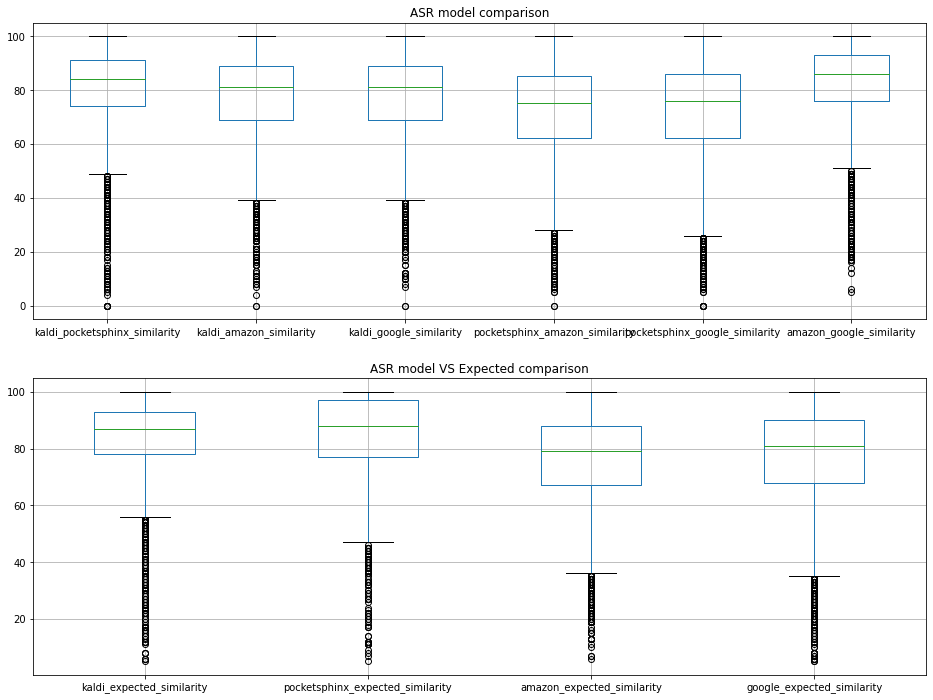

In [ ]:
## boxplot of different ASR comparison
_, ax = plt.subplots(2,1, figsize=(16,12))
ax = ax.flatten()
df_activity_phrase.boxplot(column=[c for c in similarity_cols if 'expect' not in c],ax=ax[0] )
ax[0].set_title('ASR model comparison')
df_activity_phrase.boxplot(column=[c for c in similarity_cols if 'expect' in c],ax=ax[1] )
ax[1].set_title('ASR model VS Expected comparison')

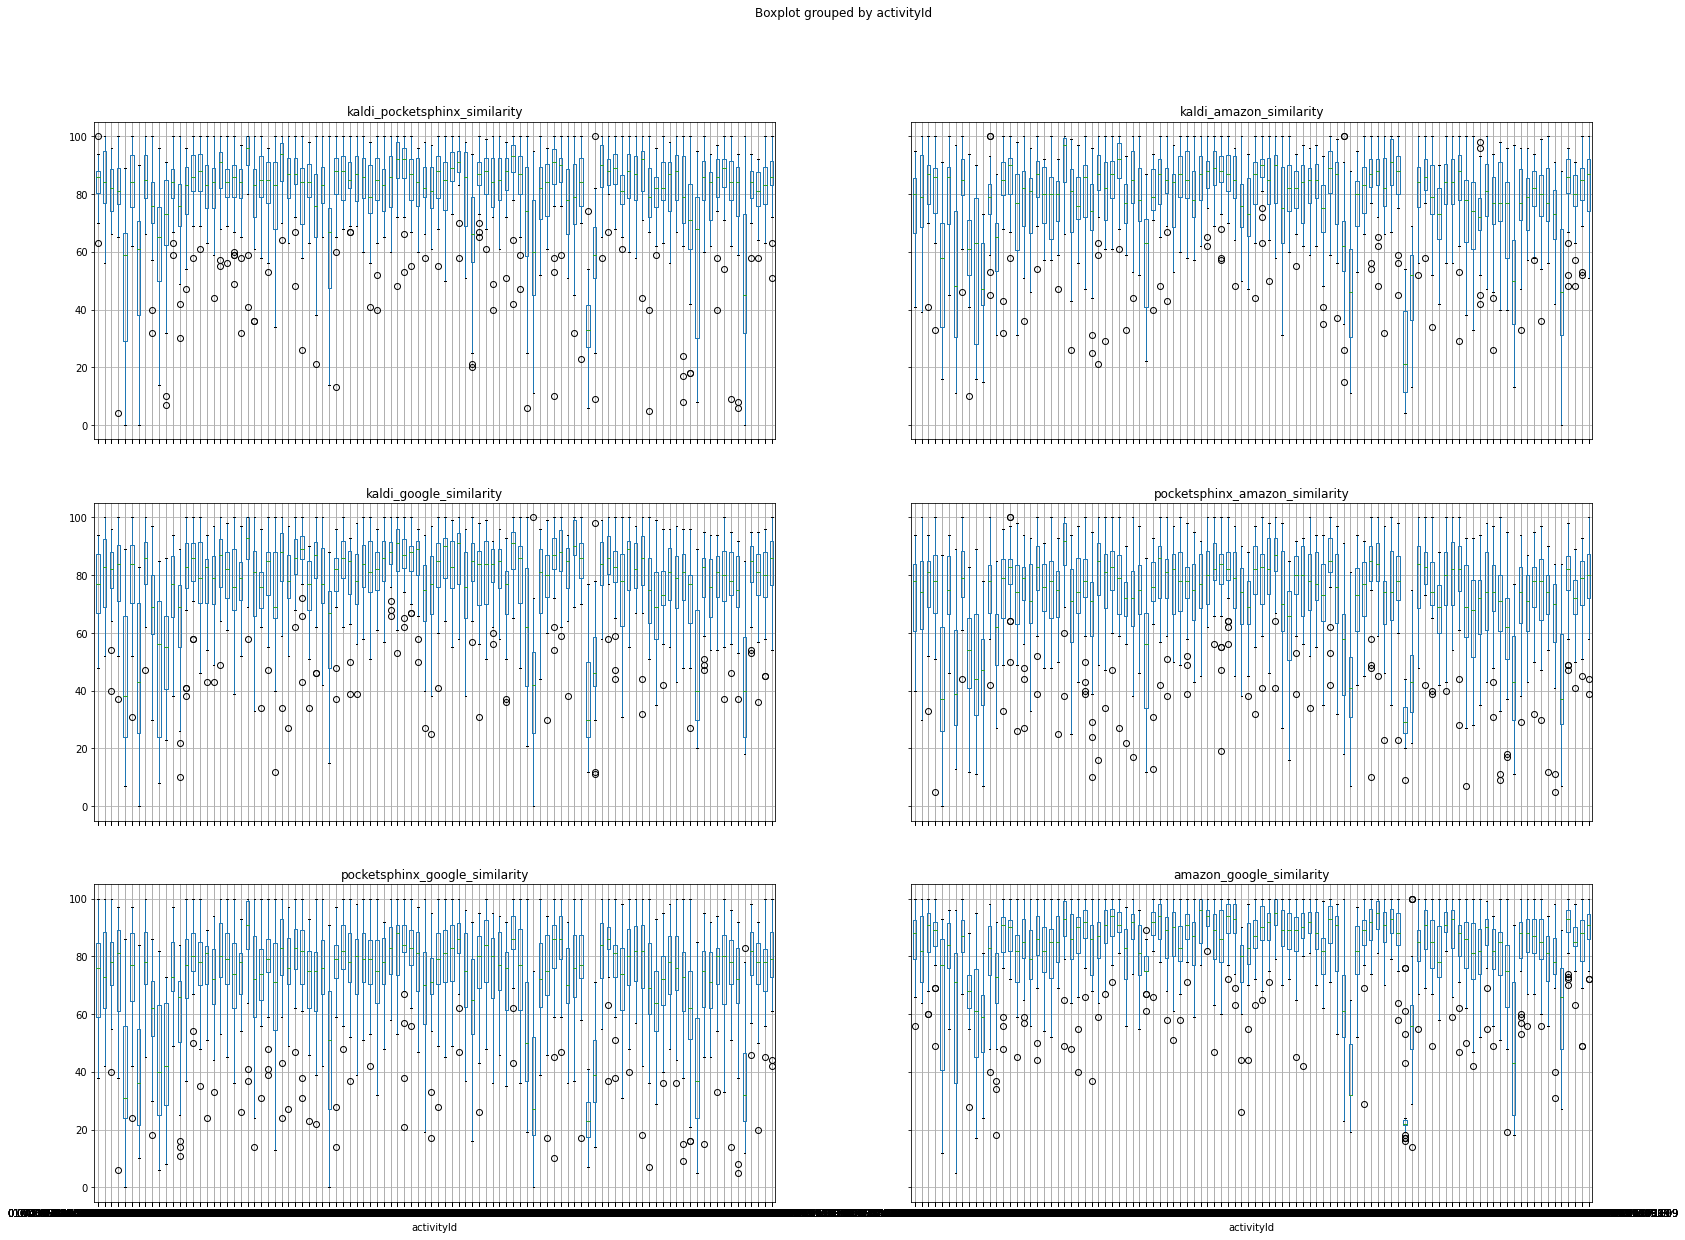

In [ ]:
## groupby activityId
df_activity_phrase.boxplot(column=[c for c in similarity_cols if 'expect' not in c],by='activityId', figsize=(26,20) );

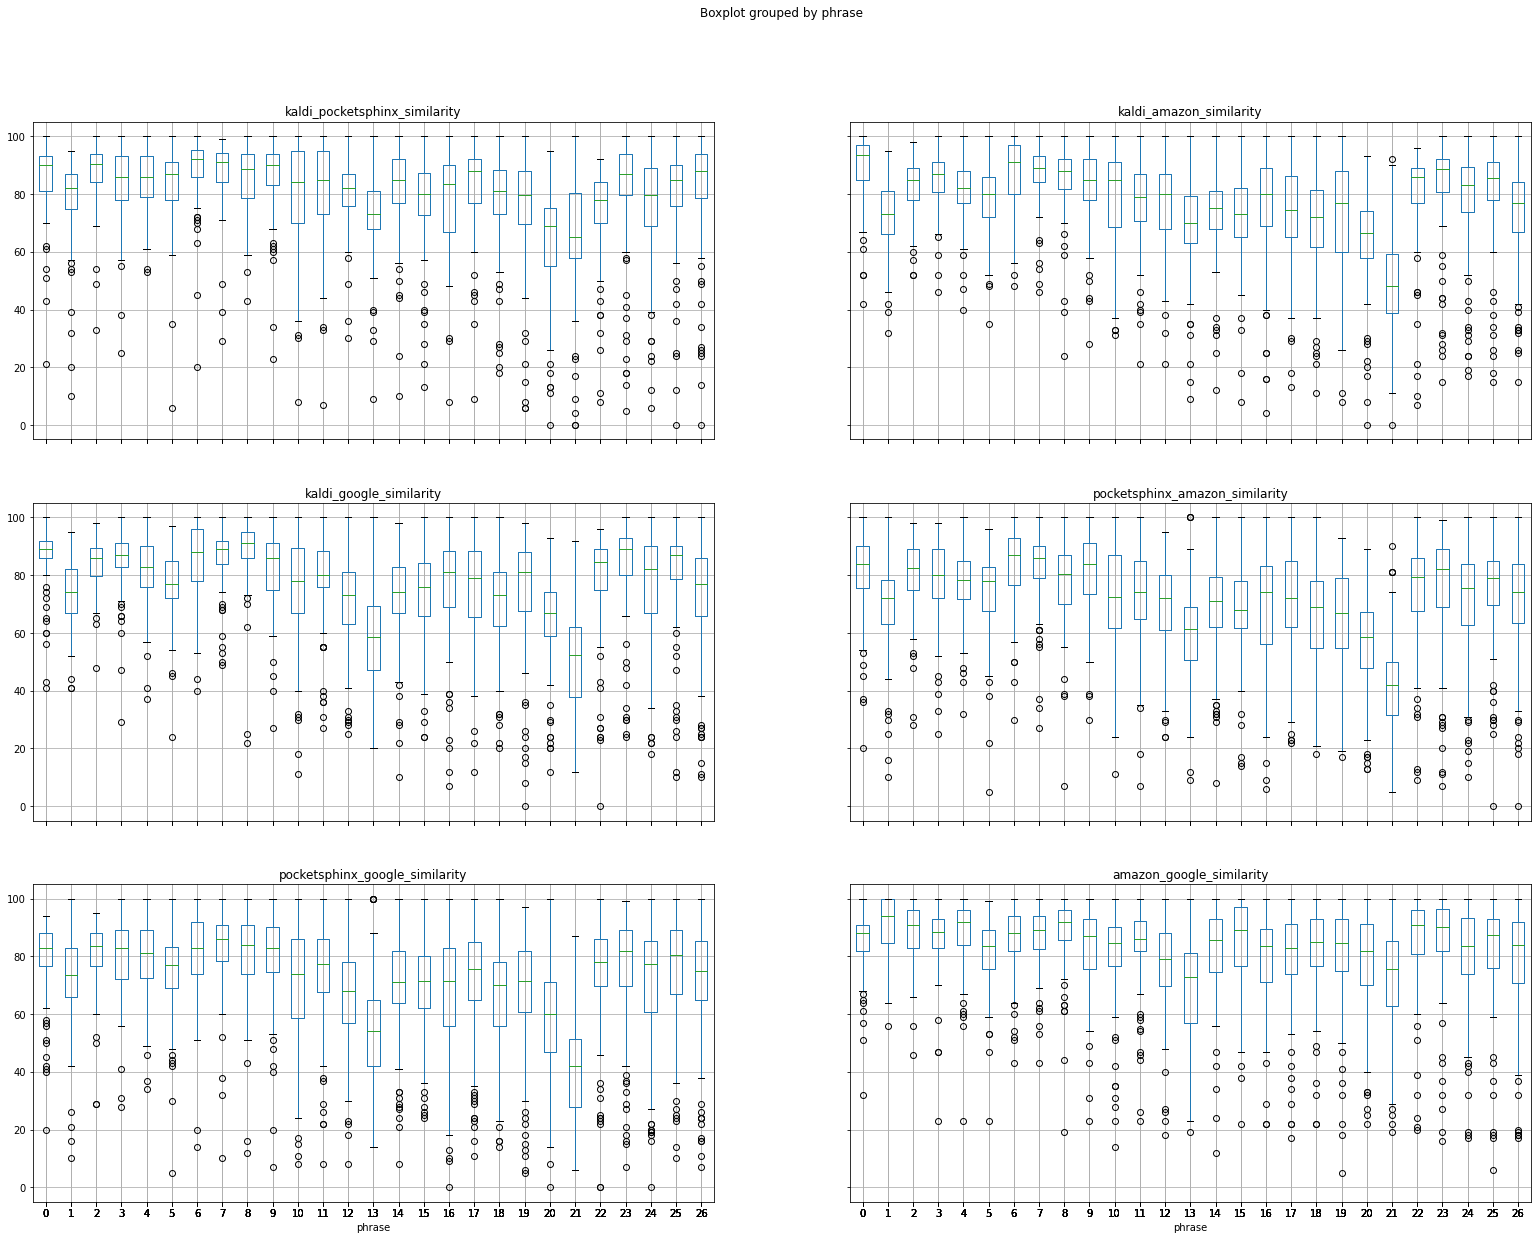

In [ ]:
## groupby phrase
df_activity_phrase.boxplot(column=[c for c in similarity_cols if 'expect' not in c],by='phrase', figsize=(26,20) );

#### Observations from the phrase level analysis
1. Among ASR services, models from google and amazon produce the similar results, so do kaldi and pocketsphnix. However, pocketsphinx transcripts are the closest to the expected results (but without additional ground truth comparison, hard to make a judgement to say it is better for this story).

2. There are clearly some sentences, like phrase 13 and 21, seems hard for kids to read. Similarly, a few activityId have worse text matching scores from different services that need a closer look.

3. In addition, we ran ANOVA test to see whether phrase_id or activityId contribute to differences in model similarity score differences


#### suggestions for potential work flow based on the analysis

1. Flag sentences where the similarity are outliers (below 50 in general)
2. Besides sentence to sentence comparison, we can run similar comparsions for the whole paragraph of each activity.

### Analyze Results at story level 

In [ ]:
## aggregate phrases into a paragraph for each activity
df_results=pd.DataFrame(df_activities['activityId'].unique(), columns=['activityId'])
kaldi=df_activities.groupby('activityId')['kaldi_text']
df_results['kaldi_text']=[kaldi.get_group(row).str.cat(sep=', ') for row in df_results['activityId']]

pocketsphinx=df_activities.groupby('activityId')['pocketsphinx_transcript']
df_results['pocketsphinx_transcript']=[pocketsphinx.get_group(row).str.cat(sep=', ') for row in df_results['activityId']]
amazon=df_activities.groupby('activityId')['amazon_transcript']
df_results['amazon_transcript']=[amazon.get_group(row).str.cat(sep=', ') for row in df_results['activityId']]

## combine utterance results to paragraphs too
df_utterance_sentence=pd.DataFrame(df_utterance['activityId'].unique(), columns=['activityId'])
utterance=df_utterance.groupby('activityId')['Utterance']
df_utterance_sentence['Utterance_sentence']=[utterance.get_group(row).str.cat(sep=' ') for row in df_utterance_sentence['activityId']]

In [ ]:
df_paragraph = df_results.merge(df_utterance_sentence, on ='activityId')

In [ ]:
## similarity score between ASR models and Human intepretation 
def paragraph_fuzzy_similarity(row, pair):
    return fuzz.token_set_ratio(row[pair[0]], row[pair[1]])

for asr in ['kaldi_text','pocketsphinx_transcript','amazon_transcript']:
  score_col_name = asr.split('_')[0] + '_accuracy'
  df_paragraph[score_col_name] = df_paragraph.apply(lambda x: paragraph_fuzzy_similarity(x, [asr, 'Utterance_sentence']), axis=1)

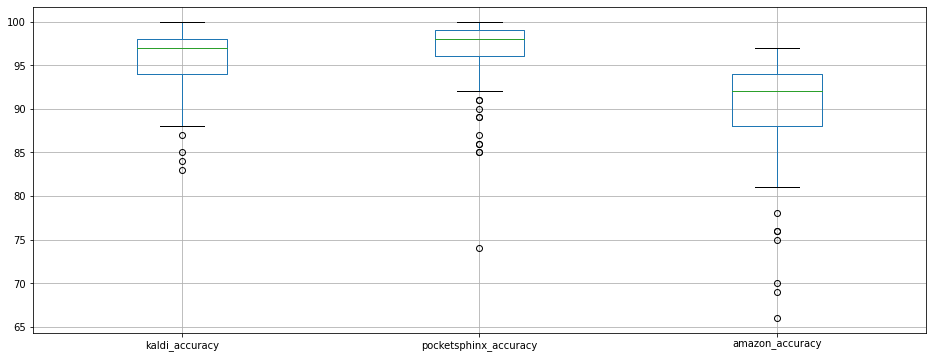

In [ ]:
## plot ASR score
df_paragraph.boxplot(column=[c for c in df_paragraph if 'accuracy' in c], figsize=(16,6) );

In [ ]:
df_paragraph[(df_paragraph.amazon_accuracy<85)&(df_paragraph.pocketsphinx_accuracy>85)]['amazon_transcript'].iloc[0]

"every day to recess mary j said of her class spits played together had, spits played together had of did it play with everybody it's said he tossed a, of did it play with everybody it's said he tossed a play ground balls over the fence at through this wigs up over the swigs at baez said the world would sweep so dollar goods like huh, huh street from here so does a wad kind sweet he even called the other kids dave's installed their stacks all the kids, stacks all the kids at school were afraid of him, were afraid of him what friday i don't best score it everyone a joy races very, a joy races very said this is sure they like this every day, they hoped at a world i'll be back but our brother he showed up in a big cast off his radar all the other, radar all the other kids wanted to door happened but no one dared to ask, that there says beria jason read out to play, the voters are the gig behind, the gig behind him struggling to try issue should we help, should we help him we re asked the,

In [ ]:
df_paragraph[(df_paragraph.amazon_accuracy<85)&(df_paragraph.pocketsphinx_accuracy>85)]['Utterance_sentence'].iloc[0]

'every day during recess mary jason and abcabcher classmates played together adam didnt play with anybody instead he tossed the playground balls over the fence and threw the swings up over the swing set bars so no one could swing he even called the other kids names and stole their snacks all the kids at school were afraid of him one friday adam missed school and everyone enjoyed recess mary said recess should be like this every day they hoped adam abcabcwo not be back abcabcbuh on monday he showed up with a big cast on his right arm all abcabc the other kids wanted to know what happened but no one dared to ask that day at recess mary and jason ran out to play they noticed adam lagging behind he was struggling to tie his shoe should we help him mary asked no way said jason but mary walked slowly over to adam anyway can i help you she asked adam looked up at her and grunted mary bent down and quickly tied his shoe then she ran back to jason why did you help him asked jason hes never nice

#### Observations on paragraph level comparison

If we consider `utterrance.csv` file as true labels and use it to calculate "accuracy score" of the transcripts from various ASR models, the plots above shows that pocketshinx transcript has the highest accuracy. Amazon transcript, on the other hand, has a wider distribution and a lower mean value of the accuracy score. Reading into the acitivity details, it seems that amazon transcript has more repeats in the phrases. It could be related to overlap of the starting and ending time of each phrase. This should be future tested. Moreover, this is only based on one story. It needs to be validated with data from more stories.

### Process and analyze the speech recognition results at the word level

In [ ]:
df_activity_word['expected_words'] = df_activities['expected_text'].apply(lambda x: re.sub("[^\w\s]", "", x).split(" "))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# # kaldi_transcription example
# cell = literal_eval(df_activity_word['amazon_word_lapse'].iloc[0])
# print("total number of words = ", len(cell), ", keys in the results are : ", cell[0] )

In [ ]:
## process kaldi transcription to words
df_activity_word['kaldi_phrase_len'] = df_activity_word['kaldi_transcription'].apply(lambda x: len(literal_eval(x)))
df_activity_word['kaldi_words'] = df_activity_word['kaldi_transcription'].apply(lambda x: [word['word'] for word in literal_eval(x)])
df_activity_word['kaldi_confidence'] = df_activity_word['kaldi_transcription'].apply(lambda x: [word['confidence'] for word in literal_eval(x)])
df_activity_word['kaldi_start_t'] = df_activity_word['kaldi_transcription'].apply(lambda x: [word['start_time'] for word in literal_eval(x)])
df_activity_word['kaldi_end_t'] = df_activity_word['kaldi_transcription'].apply(lambda x: [word['end_time'] for word in literal_eval(x)])

## process google transcription
df_activity_word['google_phrase_len'] = df_activity_word['google_word_confidence'].apply(lambda x: len(x))
df_activity_word['google_words'] = df_activity_word['google_word_confidence'].apply(lambda x: [word[0] for word in x])
df_activity_word['google_confidence'] = df_activity_word['google_word_confidence'].apply(lambda x: [word[1] for word in x])

df_activity_word = df_activity_word.drop(['kaldi_transcription', 'google_word_confidence'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
## process pocketsphinx, amazon and google transcripts
def unpack_words(df, col, cell_info='confidence'):
  '''
  unpack transcript phrases to words and get their confidence or time information if available
  '''
  col_split = col.split('_')[0]
  if col_split+'_phrase_len' not in df:
    df[col_split+'_phrase_len'] = df[col].apply(lambda x: len(literal_eval(x)))
  if col_split+'_words' not in df_activity_word:
    df[col_split+'_words'] = df[col].apply(lambda x: [word[0] for word in literal_eval(x)])
  df[col_split+'_'+cell_info] = df[col].apply(lambda x: [word[1] for word in literal_eval(x)])
  ## drop the input col
  df = df.drop(col, axis=1)

  return df

df_activity_word = unpack_words(df_activity_word, 'pocketsphinx_word_confidence')
df_activity_word = unpack_words(df_activity_word, 'amazon_word_confidence')
df_activity_word = unpack_words(df_activity_word, 'amazon_word_lapse', cell_info='lapse')
df_activity_word = unpack_words(df_activity_word, 'amazon_frame_interval', cell_info='interval')


In [ ]:
## get max phrase length from ASR transcripts and it will be used as placeholders for word unpacking
# df_activity_word['max_phrase_len'] = df_activity_word[[c for c in df_activity_word if 'len' in c]].max(axis=1)

In [ ]:
# ## unpack list cells to multiple rows and concatenate all phrase, note this is not efficient when datasets are large
df_seq = []
for service in ['kaldi', 'google', 'amazon','pocketsphinx','expected']:
  print(service)
  try:
    df_test = df_activity_word[[service+'_words', service+'_phrase_len']+general_cols]
    df_test = df_test.explode(service+'_words')
    df_test['word_id'] = df_test.groupby(['activityId', 'phrase'])[service+'_words'].cumcount()
    other_cols = [c for c in df_activity_word if service in c and 'words' not in c and 'len' not in c]
    df_test = df_test.rename(columns={service+'_words':'words', service+'_phrase_len': 'len'})
    ## unpack other cols to corresponding rows
    for c in other_cols:
      temp_df =  df_activity_word[[c, 'activityId','phrase']].explode(c)
      temp_df['word_id'] = temp_df.groupby(['activityId', 'phrase'])[c].cumcount()
      df_test = df_test.merge(temp_df, on =['activityId','phrase','word_id'], how='left')
      df_test = df_test.rename(columns={c: '_'.join(c.split('_')[1:])})
  except:
    df_test = df_activity_word[[service+'_words']+general_cols]
    df_test = df_test.explode(service+'_words')
    df_test = df_test.rename(columns={service+'_words':'words'})

  df_test['ASR_service'] = service
  
  df_seq.append(df_test)

df_activity_unpacked = pd.concat(df_seq, axis=0, ignore_index=True)

kaldi
google
amazon
pocketsphinx
expected


In [ ]:
df_activity_unpacked

,words,len,phrase,activityId,Grade_level,s3,word_id,confidence,start_t,end_t,ASR_service,lapse,interval
0,every,14.0,0,017CDA554B3311E9BEA916071609,3,017CDA554B3311E9BEA9160716090002,0.0,1,0.06,0.36,kaldi,NaN,NaN
1,day,14.0,0,017CDA554B3311E9BEA916071609,3,017CDA554B3311E9BEA9160716090002,1.0,1,0.36,0.6,kaldi,NaN,NaN
2,during,14.0,0,017CDA554B3311E9BEA916071609,3,017CDA554B3311E9BEA9160716090002,2.0,1,0.6,0.96,kaldi,NaN,NaN
3,recess,14.0,0,017CDA554B3311E9BEA916071609,3,017CDA554B3311E9BEA9160716090002,3.0,0.994768,0.96,1.47,kaldi,NaN,NaN
4,mary,14.0,0,017CDA554B3311E9BEA916071609,3,017CDA554B3311E9BEA9160716090002,4.0,1,1.47,2.16,kaldi,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146802,he,NaN,26,22795C013F7C11E9BEA916071609,3,22795C013F7C11E9BEA9160716090002,NaN,NaN,NaN,NaN,expected,NaN,NaN
146803,stopped,NaN,26,22795C013F7C11E9BEA916071609,3,22795C013F7C11E9BEA9160716090002,NaN,NaN,NaN,NaN,expected,NaN,NaN
146804,stealing,NaN,26,22795C013F7C11E9BEA916071609,3,22795C013F7C11E9BEA9160716090002,NaN,NaN,NaN,NaN,expected,NaN,NaN
146805,their,NaN,26,22795C013F7C11E9BEA916071609,3,22795C013F7C11E9BEA9160716090002,NaN,NaN,NaN,NaN,expected,NaN,NaN


#### an example of incomplete reading activity

In [ ]:
# df_activity_unpacked[(df_activity_unpacked.activityId=='FDE082113F7C11E9BEA916071609')&(df_activity_unpacked.ASR_service=='expected')].words.values

In [ ]:
# df_activity_unpacked[(df_activity_unpacked.activityId=='FDE082113F7C11E9BEA916071609')&(df_activity_unpacked.ASR_service=='amazon')].words.values

In [ ]:
# df_utterance[(df_utterance.activityId=='FDE082113F7C11E9BEA916071609')].Utterance.values

### process utterance file

In [ ]:
df_utterance['error_flag'] = df_utterance['Utterance'].apply(lambda x: 1 if 'abcabc' in x or len(re.sub("[^\w\s]", "", x))<1 else 0)
df_utterance

,Utterance,activityId,error_flag
0,every,017CDA554B3311E9BEA916071609,0
1,day,017CDA554B3311E9BEA916071609,0
2,during,017CDA554B3311E9BEA916071609,0
3,recess,017CDA554B3311E9BEA916071609,0
4,mary,017CDA554B3311E9BEA916071609,0
...,...,...,...
24366,he,22795C013F7C11E9BEA916071609,0
24367,stopped,22795C013F7C11E9BEA916071609,0
24368,stealing,22795C013F7C11E9BEA916071609,0
24369,their,22795C013F7C11E9BEA916071609,0


### build function for detection at word level (pseudo code only)

In [ ]:
def speech_word_detection_feature_eng(
    asr_inputs : Union(pd.DataFrame, list),
    expected_story : Union(str, list, pd.DataFrame),
    tolerance  : int = 3,
    confidence_threshold : float = 0.9):
  """
  the function is to use asr output, processed as a dataframe like df_activity_unpacked or a list of similar dataframes 
  to build features detecting the correctness of each word in kids reading activities

  asr_inputs: transcript of the reading activity from each ASR models at word level, include:
   1. words transcripted from models
   2. confidence of each word
   3. phraseID: order index of each sentence in the story
   4. wordID: order index of each word in the sentence

  expected_story: expected story texts, can be a long string input or a processed dataframe with each row representing 
  a word with additonal columns like sentence ID and word ID as well.

  tolerance: number of words ot match before and after the current row number

  confidence_threshold : minimum tolerance of word to keep 
  """
  
  for each word in the expected story:
    idx = index_of_this_word_in_the_sentence
    list_of_features_for_correctness_detection = [ 
    (output_word_value_from_model_at_index(idx+k),
     output_word_confidence_from_model_at_index(idx+k),                                             
    )
    for model in list_of_existing_models
        for k in range(-tolerance, tolerance+1)]


## training pipeline
encode_words --> build_features --> create_labels --> split_train_test --> training --> cross_validation

SyntaxError: ignored

#### Observations and future work

1. It seems when kids read, they could have repeats at the beginning of a new sentence, that could cause ASR models mis-interpret and reduce their accuracy in word level recognition. Moreover, it makes matching between human-interpreted results and ASR models harder as the beginning and ending of  the sentences. 

2. The guidance for kids speech tends to focus on tense, singular/plural forms and other specific areas as well, so the common-used stemming and tokenization for text mining are not appropriate options for the given scenario

3. The current notebook is based on the given sample datasets, when the data gets much larger, a lot of processing steps need to be optimized and a better way is defintely to warp up the processing in sklean-transformer classes.